<a href="https://colab.research.google.com/github/ayshaw/multimerCorrection/blob/master/GREMLIN_TF_v2_weights_edit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# GREMLIN_TF v2.1
GREMLIN implemented in tensorflow

### Change log:
*   02Apr2019
 - fixing a few hard-coded values, to allow GREMLIN to work with any alphabet (binary, protein, rna etc)
*   22Jan2019
 - moving [GREMLIN_TF_simple](https://colab.research.google.com/github/sokrypton/GREMLIN_CPP/blob/master/GREMLIN_TF_simple.ipynb) to a seperate notebook
*   19Jan2019
 - in the past we found that optimizing V first, required less iterations for convergence. Since V can be computed exactly (assuming no W), we replace this first optimization step with a simple V initialization.
 - a few variables were renamed to be consistent with the c++ version
*   16Jan2019
 - updating how indices are handled (for easier/cleaner parsing)
 - minor speed up in how we symmetrize and zero the diagional of W
*   15Jan2019
 - LBFGS optimizer replaced with a modified version of the ADAM optimizer
 - Added option for stochastic gradient descent (via batch_size)
  
### Method:
GREMLIN takes a multiple sequence alignment (MSA) and returns a Markov Random Field (MRF). The MRF consists of a one-body term (V) that encodes conservation, and a two-body term (W) that encodes co-evolution.

For more details about the method see:
[Google slides](https://docs.google.com/presentation/d/1aooxoksosSv7CWs9-ktqhUjyXR3wrgbG5a6PCr92od4/) and accompanying [Google colab](https://colab.research.google.com/drive/17RJcExuyifnd7ShTcsZGh6mBpWq0-s60)

See [GREMLIN_TF_simple](https://colab.research.google.com/github/sokrypton/GREMLIN_CPP/blob/master/GREMLIN_TF_simple.ipynb) for a stripped down version of this code (with no funky gap removal, sequence weight, etc). This is intented for educational purpose,  and could also be very useful for anyone trying to modify or improve the algorithm!


In [0]:
# ------------------------------------------------------------
# "THE BEERWARE LICENSE" (Revision 42):
# <so@g.harvard.edu> and <pkk382@g.harvard.edu> wrote this code.
# As long as you retain this notice, you can do whatever you want
# with this stuff. If we meet someday, and you think this stuff
# is worth it, you can buy us a beer in return.
# --Sergey Ovchinnikov and Peter Koo
# ------------------------------------------------------------

In [0]:
# !wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
# !unzip ngrok-stable-linux-amd64.zip

In [0]:
# LOG_DIR = './log'
# get_ipython().system_raw(
#     'tensorboard --logdir {} --host 0.0.0.0 --port 6006 &'
#     .format(LOG_DIR)
# )

In [0]:
# get_ipython().system_raw('./ngrok http 6006 &')


In [0]:
# ! curl -s http://localhost:4040/api/tunnels | python3 -c \
#     "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"

## libraries

In [2]:
# IMPORTANT, only tested using PYTHON 3!
import numpy as np
import tensorflow as tf
import matplotlib.pylab as plt
from scipy import stats
from scipy.spatial.distance import pdist,squareform
import pandas as pd
import os
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

# from keras.callbacks import TensorBoard
# tbCallBack = TensorBoard(log_dir='./log', histogram_freq=1,
#                          write_graph=True,
#                          write_grads=True,
#                          batch_size=None,
#                          write_images=True)
# from google.colab import drive
# drive.mount('/content/drive/',force_remount=True)
# os.chdir('/content/drive/My Drive/markslab/multimerCorrection')

In [3]:
!ls

analyzing_output.ipynb		  merged_top10_statistics_449.csv  README.md
GREMLIN_TF_v2.ipynb		  pd_mtx.csv
GREMLIN_TF_v2_weights_edit.ipynb  pd_mtx_weights.csv


## Params

In [4]:
################
# note: if you are modifying the alphabet
# make sure last character is "-" (gap)
################
alphabet = "ARNDCQEGHILKMFPSTWYV-"
states = len(alphabet)
a2n = {}
for a,n in zip(alphabet,range(states)):
    a2n[a] = n
################

def aa2num(aa):
    '''convert aa into num'''
    if aa in a2n: return a2n[aa]
    else: return a2n['-']

## Functions for prepping the MSA (Multiple sequence alignment)

In [5]:
# from fasta
def parse_fasta(filename,limit=-1):
    '''function to parse fasta'''
    header = []
    sequence = []
    lines = open(filename, "r")
    for line in lines:
        line = line.rstrip()
        if line[0] == ">":
            if len(header) == limit:
                break
            header.append(line[1:])
            sequence.append([])
        else:
            sequence[-1].append(line)
    lines.close()
    sequence = [''.join(seq) for seq in sequence]
    return np.array(header), np.array(sequence)

def filt_gaps(msa,gap_cutoff=0.5):
    '''filters alignment to remove gappy positions'''
    tmp = (msa == states-1).astype(np.float)
    non_gaps = np.where(np.sum(tmp.T,-1).T/msa.shape[0] < gap_cutoff)[0]
    return msa[:,non_gaps],non_gaps

def get_eff(msa,eff_cutoff=0.8):
    '''compute effective weight for each sequence'''
    ncol = msa.shape[1]

    # pairwise identity
    msa_sm = 1.0 - squareform(pdist(msa,"hamming"))

    # weight for each sequence
    msa_w = (msa_sm >= eff_cutoff).astype(np.float)
    msa_w = 1/np.sum(msa_w,-1)

    return msa_w

# def cluster(msa, method='ward', threshold=0.8):
#     Z = linkage(1-squareform(pdist(msa,"hamming")),method) 
#     return fcluster(Z,threshold,criterion='distance')
def mk_msa(seqs):
    '''converts list of sequences to msa'''

    msa_ori = []
    for seq in seqs:
        msa_ori.append([aa2num(aa) for aa in seq])
    msa_ori = np.array(msa_ori)

    # remove positions with more than > 50% gaps
    msa, v_idx = filt_gaps(msa_ori,0.5)

    # compute effective weight for each sequence
    msa_weights = get_eff(msa,0.8)

    # compute effective number of sequences
    ncol = msa.shape[1] # length of sequence
    w_idx = v_idx[np.stack(np.triu_indices(ncol,1),-1)]
#     msa_cluster = cluster(msa)
    return {"msa_ori":msa_ori,
          "msa":msa,
          "weights":msa_weights,
          "neff":np.sum(msa_weights),
          "v_idx":v_idx,
          "w_idx":w_idx,
          "nrow":msa.shape[0],
          "ncol":ncol,
          "ncol_ori":msa_ori.shape[1]}


## GREMLIN

In [6]:
# external functions

def sym_w(w):
    '''symmetrize input matrix of shape (x,y,x,y)'''
    x = w.shape[0]
    w = w * np.reshape(1-np.eye(x),(x,1,x,1))
    w = w + tf.transpose(w,[2,3,0,1])
    return w

def opt_adam(loss, name, var_list=None, lr=1.0, b1=0.9, b2=0.999, b_fix=False):
    # adam optimizer
    # Note: this is a modified version of adam optimizer. More specifically, we replace "vt"
    # with sum(g*g) instead of (g*g). Furthmore, we find that disabling the bias correction
    # (b_fix=False) speeds up convergence for our case.

    if var_list is None: var_list = tf.trainable_variables() 
    gradients = tf.gradients(loss,var_list)
    if b_fix: t = tf.Variable(0.0,"t")
    opt = []
    for n,(x,g) in enumerate(zip(var_list,gradients)):
        if g is not None:
            ini = dict(initializer=tf.zeros_initializer,trainable=False)
            mt = tf.get_variable(name+"_mt_"+str(n),shape=list(x.shape), **ini)
            vt = tf.get_variable(name+"_vt_"+str(n),shape=[], **ini)

            mt_tmp = b1*mt+(1-b1)*g
            vt_tmp = b2*vt+(1-b2)*tf.reduce_sum(tf.square(g))
            lr_tmp = lr/(tf.sqrt(vt_tmp) + 1e-8)

            if b_fix: lr_tmp = lr_tmp * tf.sqrt(1-tf.pow(b2,t))/(1-tf.pow(b1,t))

            opt.append(x.assign_add(-lr_tmp * mt_tmp))
            opt.append(vt.assign(vt_tmp))
            opt.append(mt.assign(mt_tmp))

    if b_fix: opt.append(t.assign_add(1.0))
    return(tf.group(opt))

In [7]:
def GREMLIN_weights(msa, opt_type="adam", opt_iter=100, opt_rate=1.0, batch_size=None):
  
    ##############################################################
    # SETUP COMPUTE GRAPH
    ##############################################################
    # kill any existing tensorflow graph
    tf.reset_default_graph()

    ncol = msa["ncol"] # length of sequence
    nrow = msa["nrow"] # number of sequences
    print("ncol: {},n nrow: {}".format(ncol,nrow))

    # msa (multiple sequence alignment) 
    MSA = tf.placeholder(tf.int32,shape=(None,ncol),name="msa")

    # one-hot encode msa
    OH_MSA = tf.one_hot(MSA,states)

    # msa weights
    MSA_weights = tf.placeholder(tf.float32, shape=(None,), name="msa_weights")

    # 1-body-term of the MRF
    V = tf.get_variable(name="V", 
                      shape=[ncol,states],
                      initializer=tf.zeros_initializer)

    # 2-body-term of the MRF
    W = tf.get_variable(name="W",
                      shape=[ncol,states,ncol,states],
                      initializer=tf.zeros_initializer)

    # weights for concatenation
    wb = tf.get_variable(name="wb",
                      shape=[nrow],
                      initializer=tf.ones_initializer)

    # symmetrize W
    W = sym_w(W)

    def L2(x): return tf.reduce_sum(tf.square(x))
    def L1(x): return tf

    ########################################
    # V + W
    ########################################
    VW = V + tf.tensordot(OH_MSA,W,2)

    # hamiltonian
    H = tf.reduce_sum(tf.multiply(OH_MSA,VW),axis=(1,2))

    # local Z (parition function)
    Z = tf.reduce_sum(tf.reduce_logsumexp(VW,axis=2),axis=1)

    # Psuedo-Log-Likelihood
    PLL = H - Z
    #wb = (wb-tf.reduce_min(wb))/(tf.reduce_max(wb)-tf.reduce_min(wb))
    # Regularization
    L2_V = 0.01 * L2(V)
    L2_W = 0.01 * L2(W) * 0.5 * (ncol-1) * (states-1)
    L2_wb = 0.01 * L2(wb)

    # loss function to minimize
    loss = -tf.reduce_sum(PLL*MSA_weights*wb)/tf.reduce_sum(MSA_weights*wb)
    loss = loss + (L2_V + L2_W + L2_wb)/msa["neff"]

    ##############################################################
    # MINIMIZE LOSS FUNCTION
    ##############################################################
    if opt_type == "adam":  
        opt = opt_adam(loss,"adam",lr=opt_rate)

    # generate input/feed
    def feed(feed_all=False):
        if batch_size is None or feed_all:
            return {MSA:msa["msa"], MSA_weights:msa["weights"]}
        else:
            idx = np.random.randint(0,msa["nrow"],size=batch_size)
            return {MSA:msa["msa"][idx], MSA_weights:msa["weights"][idx]}

    # optimize!
    with tf.Session() as sess:
        # initialize variables V and W
        sess.run(tf.global_variables_initializer())

        # initialize V
        msa_cat = tf.keras.utils.to_categorical(msa["msa"],states)
        pseudo_count = 0.01 * np.log(msa["neff"])
        V_ini = np.log(np.sum(msa_cat.T * msa["weights"],-1).T + pseudo_count)
        V_ini = V_ini - np.mean(V_ini,-1,keepdims=True)
        sess.run(V.assign(V_ini))

        wb_ini = sess.run(wb)

        # compute loss across all data
        get_loss = lambda: round(sess.run(loss,feed(feed_all=True)) * msa["neff"],2)
        print("starting",get_loss())

        if opt_type == "lbfgs":
            lbfgs = tf.contrib.opt.ScipyOptimizerInterface
            opt = lbfgs(loss,method="L-BFGS-B",options={'maxiter': opt_iter})
            opt.minimize(sess,feed(feed_all=True))

        if opt_type == "adam":
            for i in range(opt_iter):
                sess.run(opt,feed())  
                if (i+1) % int(opt_iter/10) == 0:
                    print("iter",(i+1),get_loss())

        # save the V and W parameters of the MRF
        V_ = sess.run(V)
        W_ = sess.run(W)
        wb_ =sess.run(wb)

    # only return upper-right triangle of matrix (since it's symmetric)
    tri = np.triu_indices(ncol,1)
    W_ = W_[tri[0],:,tri[1],:]

    mrf = {"v": V_,
         "w": W_,
         "wb": wb_,
         "wb_ini":wb_ini,
         "v_idx": msa["v_idx"],
         "w_idx": msa["w_idx"]}

    return mrf

In [8]:
def GREMLIN(msa, opt_type="adam", opt_iter=100, opt_rate=1.0, batch_size=None):

    ##############################################################
    # SETUP COMPUTE GRAPH
    ##############################################################
    # kill any existing tensorflow graph
    tf.reset_default_graph()

    ncol = msa["ncol"] # length of sequence

    # msa (multiple sequence alignment) 
    MSA = tf.placeholder(tf.int32,shape=(None,ncol),name="msa")

    # one-hot encode msa
    OH_MSA = tf.one_hot(MSA,states)

    # msa weights
    MSA_weights = tf.placeholder(tf.float32, shape=(None,), name="msa_weights")

    # 1-body-term of the MRF
    V = tf.get_variable(name="V", 
                      shape=[ncol,states],
                      initializer=tf.zeros_initializer)

    # 2-body-term of the MRF
    W = tf.get_variable(name="W",
                      shape=[ncol,states,ncol,states],
                      initializer=tf.zeros_initializer)

    # symmetrize W
    W = sym_w(W)

    def L2(x): return tf.reduce_sum(tf.square(x))

    ########################################
    # V + W
    ########################################
    VW = V + tf.tensordot(OH_MSA,W,2)

    # hamiltonian
    H = tf.reduce_sum(tf.multiply(OH_MSA,VW),axis=(1,2))

    # local Z (parition function)
    Z = tf.reduce_sum(tf.reduce_logsumexp(VW,axis=2),axis=1)

    # Psuedo-Log-Likelihood
    PLL = H - Z
    # Regularization
    L2_V = 0.01 * L2(V)
    L2_W = 0.01 * L2(W) * 0.5 * (ncol-1) * (states-1)


    # loss function to minimize
    loss = -tf.reduce_sum(PLL*MSA_weights)/tf.reduce_sum(MSA_weights)
    loss = loss + (L2_V + L2_W)/msa["neff"]

    ##############################################################
    # MINIMIZE LOSS FUNCTION
    ##############################################################
    if opt_type == "adam":  
        opt = opt_adam(loss,"adam",lr=opt_rate)

    # generate input/feed
    def feed(feed_all=False):
        if batch_size is None or feed_all:
            return {MSA:msa["msa"], MSA_weights:msa["weights"]}
        else:
            idx = np.random.randint(0,msa["nrow"],size=batch_size)
        return {MSA:msa["msa"][idx], MSA_weights:msa["weights"][idx]}

    # optimize!
    with tf.Session() as sess:
        # initialize variables V and W
        sess.run(tf.global_variables_initializer())

        # initialize V
        msa_cat = tf.keras.utils.to_categorical(msa["msa"],states)
        pseudo_count = 0.01 * np.log(msa["neff"])
        V_ini = np.log(np.sum(msa_cat.T * msa["weights"],-1).T + pseudo_count)
        V_ini = V_ini - np.mean(V_ini,-1,keepdims=True)
        sess.run(V.assign(V_ini))

        # compute loss across all data
        get_loss = lambda: round(sess.run(loss,feed(feed_all=True)) * msa["neff"],2)
        print("starting",get_loss())

        if opt_type == "lbfgs":
            lbfgs = tf.contrib.opt.ScipyOptimizerInterface
            opt = lbfgs(loss,method="L-BFGS-B",options={'maxiter': opt_iter})
            opt.minimize(sess,feed(feed_all=True))

        if opt_type == "adam":
            for i in range(opt_iter):
                sess.run(opt,feed())  
                if (i+1) % int(opt_iter/10) == 0:
                    print("iter",(i+1),get_loss())

        # save the V and W parameters of the MRF
        V_ = sess.run(V)
        W_ = sess.run(W)

    # only return upper-right triangle of matrix (since it's symmetric)
    tri = np.triu_indices(ncol,1)
    W_ = W_[tri[0],:,tri[1],:]

    mrf = {"v": V_,
         "w": W_,
         "v_idx": msa["v_idx"],
         "w_idx": msa["w_idx"]}

    return mrf

## EXAMPLE

In [9]:
# download example fasta MSA
!wget -q -nc https://gremlin2.bakerlab.org/db/PDB_EXP/fasta/4FAZA.fas

In [10]:
# ===============================================================================
# PREP MSA
# ===============================================================================
# parse fasta
names, seqs = parse_fasta("concat.a2m")

# process input sequences
msa = mk_msa(seqs)



FileNotFoundError: [Errno 2] No such file or directory: 'concat.a2m'

In [0]:
with open("names.txt", "w+") as output:
    output.write(str(names.tolist()))
print('finished writing')
with open("seqs.txt", "w+") as output:
    output.write(str(seqs.tolist()))

finished writing


In [14]:
%%time
# ===============================================================================
# RUN GREMLIN
# ===============================================================================
# Note: the original GREMLIN uses the "lbfgs" optimizer which is EXTREMELY slow 
# in tensorflow. The modified adam optimizer is much faster, but may 
# require adjusting number of iterations (opt_iter) to converge to the same 
# solution. To switch back to the original, set opt_type="lbfgs".
# ===============================================================================
mrf_weights = GREMLIN_weights(msa)

ncol: 156,n nrow: 33949
starting 2234555.7
iter 10 610425.81
iter 20 -1004709.96
iter 30 2614624064.39
iter 40 21260721.45
iter 50 10114460.88
iter 60 7487215.8
iter 70 6360375.55
iter 80 5644785.54
iter 90 5094242.77
iter 100 4632399.83
CPU times: user 18 s, sys: 10.4 s, total: 28.5 s
Wall time: 45.6 s


In [15]:
%%time
# ===============================================================================
# RUN GREMLIN
# ===============================================================================
# Note: the original GREMLIN uses the "lbfgs" optimizer which is EXTREMELY slow 
# in tensorflow. The modified adam optimizer is much faster, but may 
# require adjusting number of iterations (opt_iter) to converge to the same 
# solution. To switch back to the original, set opt_type="lbfgs".
# ===============================================================================
mrf = GREMLIN(msa)

starting 2234216.28
iter 10 783023.4
iter 20 574726.56
iter 30 511102.8
iter 40 472315.75
iter 50 449315.18
iter 60 438720.97
iter 70 434541.42
iter 80 432790.55
iter 90 431951.48
iter 100 431520.99
CPU times: user 18.6 s, sys: 10.9 s, total: 29.5 s
Wall time: 47.7 s


## Explore the contact map
### Contact prediction:

For contact prediction, the W matrix is reduced from LxLx21x21 to LxL matrix (by taking the L2norm for each of the 20x20). In the code below, you can access this as mtx["raw"]. Further correction (average product correction) is then performed to the mtx["raw"] to remove the effects of entropy, mtx["apc"]. The relative ranking of mtx["apc"] is used to assess importance. When there are enough effective sequences (>1000), we find that the top 1.0L contacts are ~90% accurate! When the number of effective sequences is lower, NN can help clean noise and fill in missing contacts.


## Functions for extracting contacts from MRF

In [0]:
###################
def normalize(x):
  x = stats.boxcox(x - np.amin(x) + 1.0)[0]
  x_mean = np.mean(x)
  x_std = np.std(x)
  return((x-x_mean)/x_std)

def get_mtx(mrf):
  '''get mtx given mrf'''
  
  # l2norm of 20x20 matrices (note: we ignore gaps)
  raw = np.sqrt(np.sum(np.square(mrf["w"][:,:-1,:-1]),(1,2)))
  raw_sq = squareform(raw)

  # apc (average product correction)
  ap_sq = np.sum(raw_sq,0,keepdims=True)*np.sum(raw_sq,1,keepdims=True)/np.sum(raw_sq)
  apc = squareform(raw_sq - ap_sq, checks=False)

  mtx = {"i": mrf["w_idx"][:,0],
         "j": mrf["w_idx"][:,1],
         "raw": raw,
         "apc": apc,
         "zscore": normalize(apc)}
  return mtx

def plot_mtx(mtx,key="zscore",vmin=1,vmax=3):
  '''plot the mtx'''
  plt.figure(figsize=(5,5))
  plt.imshow(squareform(mtx[key]), cmap='Blues', interpolation='none', vmin=vmin, vmax=vmax)
  plt.grid(False)
  plt.show()

In [0]:
mtx_weights = get_mtx(mrf_weights)  
mtx = get_mtx(mrf)
#plot_mtx(mtx)

## Look at top co-evolving residue pairs

In [20]:
######################################################################################
# WARNING - WARNING - WARNING
######################################################################################
# - the i,j index starts at 0 (zero)
# - the "first" position = 0
# - often in biology first position of a sequence is 1
#   for this index use i_aa and j_aa!

# adding amino acid to index
mtx["i_aa"] = np.array([alphabet[msa['msa_ori'][0][i]]+"_"+str(i+1) for i in mtx["i"]])
mtx["j_aa"] = np.array([alphabet[msa['msa_ori'][0][j]]+"_"+str(j+1) for j in mtx["j"]])

mtx_weights["i_aa"] = np.array([alphabet[msa['msa_ori'][0][i]]+"_"+str(i+1) for i in mtx_weights["i"]])
mtx_weights["j_aa"] = np.array([alphabet[msa['msa_ori'][0][j]]+"_"+str(j+1) for j in mtx_weights["j"]])


# load mtx into pandas dataframe
pd_mtx = pd.DataFrame(mtx,columns=["i","j","apc","zscore","i_aa","j_aa"])
pd_mtx_weights = pd.DataFrame(mtx_weights,columns=["i","j","apc","zscore","i_aa","j_aa"])
# get contacts with sequence seperation > 5
# sort by zscore, show top 10
top = pd_mtx.loc[pd_mtx['j'] - pd_mtx['i'] > 5].sort_values("zscore",ascending=False)
top.head(10)

,i,j,apc,zscore,i_aa,j_aa
5998,70,84,0.934015,2.070271,C_71,F_85
5995,70,81,0.898577,2.013181,C_71,A_82
6327,73,89,0.882275,1.986596,P_74,E_90
6326,73,88,0.878822,1.980937,P_74,L_89
3580,50,56,0.859729,1.949481,V_51,D_57
3581,50,57,0.826457,1.893965,V_51,V_58
6739,77,83,0.826383,1.893841,R_78,R_84
5548,66,80,0.823379,1.888784,K_67,A_81
6436,74,92,0.823044,1.888219,N_75,M_93
5088,62,82,0.817150,1.878274,P_63,S_83


In [0]:
def plot_top_n_contacts(df):
  
  for index,row in df.nlargest(100,'apc').iterrows():
      plt.scatter(row.i,row.j,s=row.apc,c='g')
      plt.scatter(row.j,row.i,s=row.apc,c='g')
  plt.axis('square')

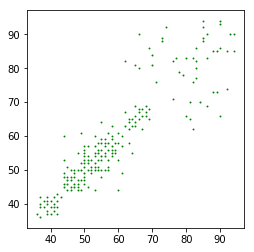

In [22]:
plot_top_n_contacts(pd_mtx)

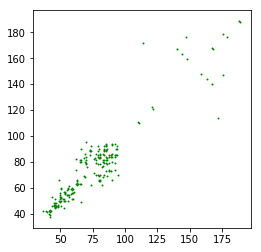

In [24]:
plot_top_n_contacts(pd_mtx_weights)

In [0]:
pd_mtx.to_csv('pd_mtx.csv')
pd_mtx_weights.to_csv('pd_mtx_weights.csv')

## Explore the MRF

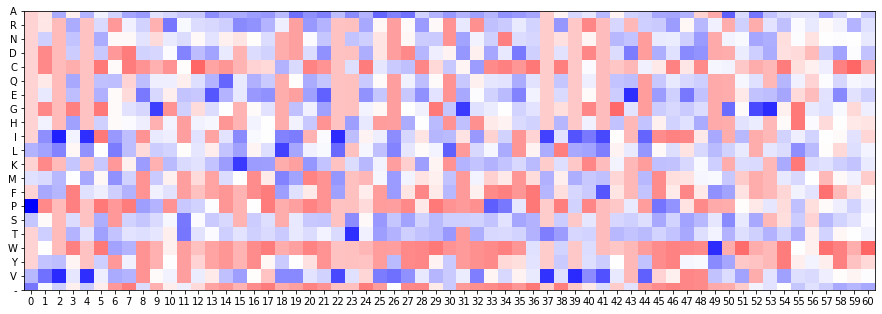

In [0]:
def plot_v(mrf):  
  al_a = list(alphabet)
  v = mrf["v"].T
  mx = np.max((v.max(),np.abs(v.min())))
  plt.figure(figsize=(v.shape[1]/4,states/4))
  plt.imshow(-v,cmap='bwr',vmin=-mx,vmax=mx)
  plt.xticks(np.arange(v.shape[1]))
  plt.yticks(np.arange(0,states))
  plt.grid(False)
  ax = plt.gca()
  ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x,y: mrf["v_idx"][x])) 
  ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x,y: al_a[x]))
  
plot_v(mrf)

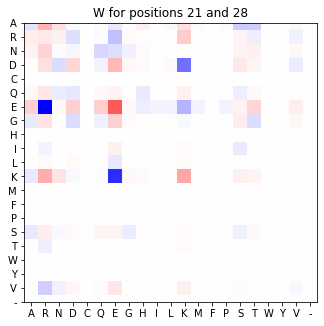

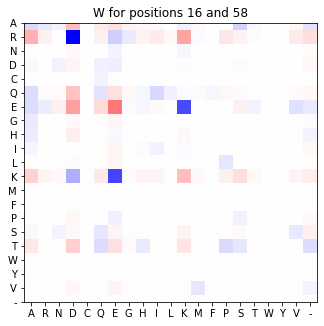

In [0]:
def plot_w(mrf,i,j):
  
  n = int(np.where((mrf["w_idx"][:,0] == i)&(mrf["w_idx"][:,1] == j))[0])
  w = mrf["w"][n]
  
  mx = np.max((w.max(),np.abs(w.min())))
  plt.figure(figsize=(states/4,states/4))
  plt.imshow(-w,cmap='bwr',vmin=-mx,vmax=mx)
  plt.xticks(np.arange(0,states))
  plt.yticks(np.arange(0,states))
  plt.grid(False)
  
  ax = plt.gca()
  al_a = list(alphabet)
  ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x,y: al_a[x])) 
  ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x,y: al_a[x]))
  plt.title(f"W for positions {i} and {j}")
  plt.show()

for n in range(2):
  i = int(top.iloc[n]["i"])
  j = int(top.iloc[n]["j"])
  plot_w(mrf,i,j)

## validating output
(comparing to known output from GREMLIN_cpp version)

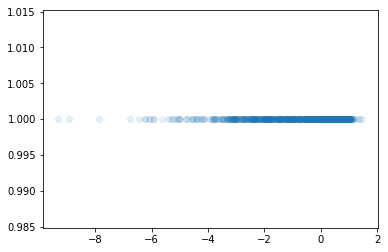

In [0]:
plt.scatter(mrf_weights['wb'],mrf_weights['wb_ini'],alpha=0.1)
#plt.axis('square')

In [0]:
!wget -q -nc http://files.ipd.uw.edu/krypton/4FAZA.out

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: read_table is deprecated, use read_csv instead.
  """Entry point for launching an IPython kernel.


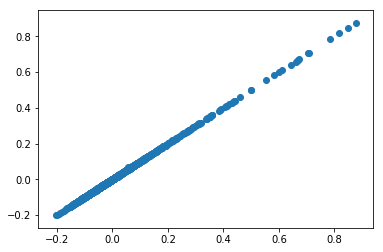

In [0]:
pd_test = pd.read_table("4FAZA.out",sep=" ")
plt.scatter(pd_test["apc"],mtx["apc"])
plt.show()

## Useful input features for NN (Neural Networks)

The "apc" values are typically used as input to the NN for contact cleaning or structure prediction. Though in recent advances (aka DeepMind/Alphafold), the entire MRF was used as the input. More specificially LxLx442. The 442 channels are the 21x21 + (raw and/or apc) value.

In [0]:
w_out = np.zeros((msa["ncol_ori"], msa["ncol_ori"], states * states + 1))
v_out = np.zeros((msa["ncol_ori"], states))

mrf_ = np.reshape(mrf["w"],(-1, states * states))
mtx_ = np.expand_dims(mtx["apc"],-1)

w_out[(mtx["i"],mtx["j"])] = np.concatenate((mrf_, mtx_),-1)
w_out += np.transpose(w_out,(1,0,2))
v_out[mrf["v_idx"]] = mrf["v"]

print("w_out",w_out.shape)
print("v_out",v_out.shape)

w_out (62, 62, 442)
v_out (62, 21)
